# Softmax Actor-Critic Function Validation

### Imports & Constants

In [1]:
import serial
import time
import random
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import tqdm
from tqdm import tqdm

In [2]:
from experiment_functions import *
from test_env import TestEnv

In [3]:
# Declare random seed
RANDOM_SEED = 1
random.seed(RANDOM_SEED)

In [4]:
# Set default constants
ARRAY_DIMENSION_TUPLE = (37,37)
MOTOR_ANGLE_POWER_DRAW = 0.0001

### Helper Functions

Preparing data from experiment results

In [5]:
# Load in logged solar data for the experiment
def load_and_prep_data(data_path):
    raw_df = pd.read_csv(data_path)
    data_df = raw_df.copy()
    # Make current positive
    data_df = data_df.drop_duplicates(subset=['motor_1_position','motor_2_position'])
    data_df['I_ivp_1'] = data_df['I_ivp_1'].abs()
    data_df['power'] = data_df['I_ivp_1'] * data_df['V_ivp_1']
    return data_df

In [6]:
def rolling_avg_calc(value, last_value, window):
    return (1/window)*value + (1-(1/window))*last_value

Converting index positions

In [7]:
def convert_motor_positions_to_2d_index(position_tuple):
    # position tuple is (m1 position, m2 position)
    return (int(position_tuple[0]//5), int(position_tuple[1]//5))

def convert_2d_index_to_motor_positions(index_tuple):
    return (index_tuple[0]*5, index_tuple[1]*5)

def convert_1d_index_to_2d_index(index, dimensions=ARRAY_DIMENSION_TUPLE):
    return np.unravel_index(index, dimensions)

def convert_2d_index_to_1d_index(index_tuple, dimensions=ARRAY_DIMENSION_TUPLE):
    return np.ravel_multi_index(index_tuple, dimensions)

def convert_motor_positions_to_1d_index(position_tuple, dimensions=ARRAY_DIMENSION_TUPLE):
    return convert_2d_index_to_1d_index(convert_motor_positions_to_2d_index(position_tuple), dimensions)

def convert_1d_index_to_motor_positions(index, dimensions=ARRAY_DIMENSION_TUPLE):
    return convert_2d_index_to_motor_positions(convert_1d_index_to_2d_index(index, dimensions))

Policy softmax

In [8]:
def softmax_prob(actor_av_array, temperature=1):
    # Divide all values by temperature
    temperature_array = actor_av_array/temperature
    
    # Find max state value
    max_value = np.max(temperature_array)
    
    # Generate the numerator for each element by subtracting max value and exponentiating
    numerator_array = temperature_array - max_value
    numerator_array = np.exp(numerator_array)

    # Get the denominator by summing all values in the numerator
    denominator_array = np.sum(numerator_array)
    
    
    # Calculate the softmax value array and return to agent
    softmax_array = numerator_array / denominator_array
    
    return softmax_array

### Agent Functions

In [189]:
class SoftmaxAgent:
    def __init__(self, actor_step_size, critic_step_size, avg_reward_step_size, temperature_value, env_shape, reward_rolling_avg_window, 
                 random_seed=RANDOM_SEED, actor_init_value=None, critic_init_value=None):
        # Set step sizes
        self.actor_step_size = actor_step_size
        self.critic_step_size = critic_step_size
        self.avg_reward_step_size = avg_reward_step_size
        self.temperature = temperature_value
        
        # Set up memory for the actor and critic
        self.env_shape = env_shape
        max_index_2d = self.env_shape[0] - 1
        max_index_1d = convert_2d_index_to_1d_index((max_index_2d, max_index_2d), dimensions=self.env_shape)
        self.agent_shape = (max_index_1d + 1, max_index_1d + 1)
        
        # Set init values of actor and critic
        # Actor
        if actor_init_value:
            self.actor_array = np.full(self.agent_shape, actor_init_value)
        else:
            self.actor_array = np.zeros(self.agent_shape)
        # Critic
        if critic_init_value:
            self.critic_array = np.full(self.agent_shape, critic_init_value)
        else:
            self.critic_array = np.zeros(self.agent_shape)
        
        # Create the actions and feature vectors
        self.actions_vector = np.array(range(0, max_index_1d + 1))
        self.base_feature_vector = np.zeros(max_index_1d + 1)
        
        # Set up fields for agent steps -- all agent internal functions are 1d index
        self.random_generator = np.random.RandomState(random_seed) 
        self.last_state = None
        self.last_action = None
        self.state = None
        self.last_reward = None
        self.avg_reward = 0
        self.step_softmax_prob = None
    
        # Set up tracking metric items
        self.state_visits = np.zeros(self.env_shape) # track in 2d to better map to env map
        self.total_reward = 0
        self.rolling_reward = 0
        self.rolling_window = reward_rolling_avg_window
        self.transition_dict = None
    
    # Agent Operation
    # =============================================
    def agent_start(self):
        # Initialize the agent
        self.avg_reward = 0
        self.last_state = self.agent_shape[0]//2
        self.last_action = self.last_state
        self.last_reward = 0
        
        # For tracking
        self.state_visits[convert_1d_index_to_2d_index(self.last_state, dimensions=self.env_shape)] += 1
    
    
    def agent_policy(self):
        # Compute the softmax prob for actions in given state
        softmax_prob_array = softmax_prob(self.actor_array[self.last_state], self.temperature)
        
        # Overlay the softmax probs onto actions vector
        chosen_action = self.random_generator.choice(self.actions_vector, p=softmax_prob_array)
        
        # save softmax_prob as it will be useful later when updating the Actor
        self.step_softmax_prob = softmax_prob_array.copy()
        self.last_action = chosen_action
        
        # Return the 1d index of action
        return chosen_action
        
    
    def agent_step(self, reward, next_state):
        # next_state = convert_2d_index_to_1d_index(next_state_tuple, dimensions=self.env_shape())
        # Compute delta
        # delta = reward - self.avg_reward + np.sum(self.critic_array[next_state]) - np.sum(self.critic_array[self.last_state])
        # delta = reward - self.avg_reward + np.mean(self.critic_array[next_state]) - np.mean(self.critic_array[self.last_state])
        # delta = reward - self.avg_reward + np.max(self.critic_array[next_state]) - np.max(self.critic_array[self.last_state])
        delta = reward - self.avg_reward
        
        # Update avg reward
        self.avg_reward += self.avg_reward_step_size * delta
        
        # Update critic weights
        self.critic_array[self.last_state][self.last_action] += self.critic_step_size * delta
        
        # Update actor weights
        feature_vector = self.base_feature_vector.copy() # copy the zeros vector
        feature_vector[self.last_action] = 1 # set last action to one
        self.actor_array[self.last_state] += self.actor_step_size * delta * (feature_vector - self.step_softmax_prob)
        
        # Update last state, etc
        self.last_state = next_state
        
        # For tracking
        self.total_reward += reward
        self.rolling_reward = rolling_avg_calc(reward, self.rolling_reward, self.rolling_window)
        self.state_visits[convert_1d_index_to_2d_index(self.last_state, self.env_shape)] += 1
        self.last_delta = delta
        
    def calculate_rolling_avg(new_value, rolling_value):
        ## RESUME HERE
        # Calculate rolling avg of reward, rolling avg of state values from critic
        # Use both of these inputs in delta
        # See if it helps with convergence in shifting state realm
        
        
    def agent_step_rolling_avg(self, reward, next_state):
        # Update reward moving avg
        self.rolling_reward_avg
        
        # Update state value moving avg
        self.rolling_state_value = cal
        
        # Compute delta
        delta = reward - self.avg_reward + np.mean(self.critic_array[next_state]) - self.rolling_state_value
        
        # Update avg reward
        self.avg_reward += self.avg_reward_step_size * delta
        
        # Update critic weights
        self.critic_array[self.last_state][self.last_action] += self.critic_step_size * delta
        
        # Update actor weights
        feature_vector = self.base_feature_vector.copy() # copy the zeros vector
        feature_vector[self.last_action] = 1 # set last action to one
        self.actor_array[self.last_state] += self.actor_step_size * delta * (feature_vector - self.step_softmax_prob)
        
        # Update last state, etc
        self.last_state = next_state
        
        # For tracking
        self.total_reward += reward
        self.rolling_reward = rolling_avg_calc(reward, self.rolling_reward, self.rolling_window)
        self.state_visits[convert_1d_index_to_2d_index(self.last_state, self.env_shape)] += 1
        self.last_delta = delta
    
    # Tracking
    # =============================================
    
    def get_critic_array(self):
        return self.critic_array.copy()
    
    def get_actor_array(self):
        return self.actor_array.copy()
    
    def set_actor_array(self, array):
        self.actor_array = array
        
    def get_actions_vector(self):
        return self.actions_vector
    
    def get_agent_avg_reward(self):
        return self.avg_reward
    
    def get_agent_last_delta(self):
        return self.last_delta
    
    def get_agent_last_state(self):
        return self.last_state
    
    def get_base_feature_vector(self):
        return self.base_feature_vector
    
    def get_agent_total_reward(self):
        return self.total_reward
    
    def get_agent_rolling_reward(self):
        return self.rolling_reward
    
    def get_transition_dict(self):
        return self.transition_dict
    
    def get_state_visits(self):
        return self.state_visits.copy()

## Experiment Set Up

#### Experiment Functions

In [190]:
def run_experiment_step(env:TestEnv, agent:SoftmaxAgent, exp_dict_list, step, step_interval):
    action = agent.agent_policy()
    reward, next_state_tuple = env.env_step(convert_1d_index_to_2d_index(action, env.get_env_shape()), 
                                            convert_1d_index_to_2d_index(agent.get_agent_last_state(), env.get_env_shape()))
    agent.agent_step(reward, convert_2d_index_to_1d_index(next_state_tuple, env.get_env_shape()))
    
    if step % step_interval == 0:
        exp_dict_list.append(
            {'step': step,
             'reward': reward,
             'avg_reward': agent.get_agent_avg_reward(),
             'rolling_reward': agent.get_agent_rolling_reward(),
             'total_reward': agent.get_agent_total_reward(),
             'optimal_reward': np.max(env.get_reward_array()),
             'delta': agent.get_agent_last_delta(),
             'actor_array': agent.get_actor_array().copy(),
             'critic_array': agent.get_critic_array().copy()
            }
        )

In [191]:
def assess_step(env:TestEnv, agent:SoftmaxAgent, env_1d_mapping, exp_dict_list, plot_width=600, plot_height=600):
    print('True Rewards')
    # fig_env = px.imshow(env.get_reward_array(), text_auto=True, width=plot_width, height=plot_height)
    # fig_env.show()
    fig_env = px.imshow(env_1d_mapping, text_auto=True, width=plot_width, height=plot_height)
    fig_env.show()
    
    print('\nCritic Rewards')
    fig_critic = px.imshow(exp_agent.get_critic_array(), text_auto=True, width=plot_width, height=plot_height)
    fig_critic.show()
    
    print('\nActor Array')
    fig_actor = px.imshow(exp_agent.get_actor_array(), text_auto=True, width=plot_width, height=plot_height)
    fig_actor.show()
    
    print('\nReward Tracking')
    make_subplots_plot(df=pd.DataFrame(exp_dict_list), x='step', 
                   subplot_group_list=[
                        {
                            'title': 'Reward Comparison (Agent vs Max)',
                             'columns': ['optimal_reward', 'rolling_reward']
                        },
                       {
                            'title': 'Avg Reward Comparison (Agent vs Max)',
                             'columns': ['optimal_reward', 'avg_reward']
                        },
                       {
                            'title': 'Instant Reward Comparison (Agent vs Max)',
                             'columns': ['optimal_reward', 'reward']
                        },
                       {
                            'title': 'Delta Comparison',
                             'columns': ['delta']
                        },
                       {
                            'title': 'Total Reward',
                             'columns': ['total_reward']
                        }
                       
                   ], 
                   width=800, height=800)

In [192]:
def create_1d_truth_mapping(env:TestEnv):
    env_shape = env.get_env_shape()
    max_2d_tuple = (env_shape[0] - 1, env_shape[1] - 1)
    max_1d_index = convert_2d_index_to_1d_index(max_2d_tuple, dimensions=env_shape)
    truth_array = np.zeros((max_1d_index + 1, max_1d_index + 1))
    for i in range(0, max_1d_index + 1):
        for j in range(0, max_1d_index + 1):
            last_state = convert_1d_index_to_2d_index(i, env_shape)
            action = convert_1d_index_to_2d_index(j, env_shape)
            truth_array[i][j] = env.env_step(action_tuple=action, last_state_tuple=last_state)[0]
    return truth_array

### Set up Exp Clas

In [193]:
# Set up environment
experiment_reward_array = np.array(
    [[0, 1, 0, 0],
     [0, 2, 0, 0],
     [0, 3, 0, 0],
     [0, 4, 0, 0]]
)
exp_env = TestEnv(experiment_reward_array, movement_penalty=0.1)
env_1d_mapping = create_1d_truth_mapping(exp_env)

In [194]:
# Set up agent

# Agent factors
exp_actor_step_size = 0.1
exp_temperature = 1
exp_critic_step_size = 0.1
exp_avg_reward_step_size = 0.001
exp_rolling_avg_steps = 10
exp_random_seed = RANDOM_SEED

### Start Agent

In [195]:
experiment_steps = 4000
logging_interval = 100
running_dict_list = []
do_flip = True

In [196]:
exp_agent = SoftmaxAgent(actor_step_size=exp_actor_step_size, critic_step_size=exp_critic_step_size,
                                avg_reward_step_size=exp_avg_reward_step_size,
                                temperature_value=exp_temperature, env_shape=exp_env.get_env_shape(), 
                                reward_rolling_avg_window=exp_rolling_avg_steps, random_seed=exp_random_seed)

In [197]:
exp_agent.agent_start()

In [198]:
if not do_flip:
    for i in tqdm(range(experiment_steps)):
        run_experiment_step(exp_env, exp_agent, running_dict_list, step=i, step_interval=logging_interval)
else:
    exp_env_1 = TestEnv(experiment_reward_array, movement_penalty=0.1)
    for i in tqdm(range(experiment_steps//2)):
        run_experiment_step(exp_env_1, exp_agent, running_dict_list, step=i, step_interval=logging_interval)
    # Swap env
    exp_env_2 = TestEnv(np.fliplr(experiment_reward_array), movement_penalty=0.1)
    for i in tqdm(range(experiment_steps//2, experiment_steps)):
        run_experiment_step(exp_env_2, exp_agent, running_dict_list, step=i, step_interval=logging_interval)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 33238.66it/s]


In [199]:
# test_df = pd.DataFrame(running_dict_list)

True Rewards


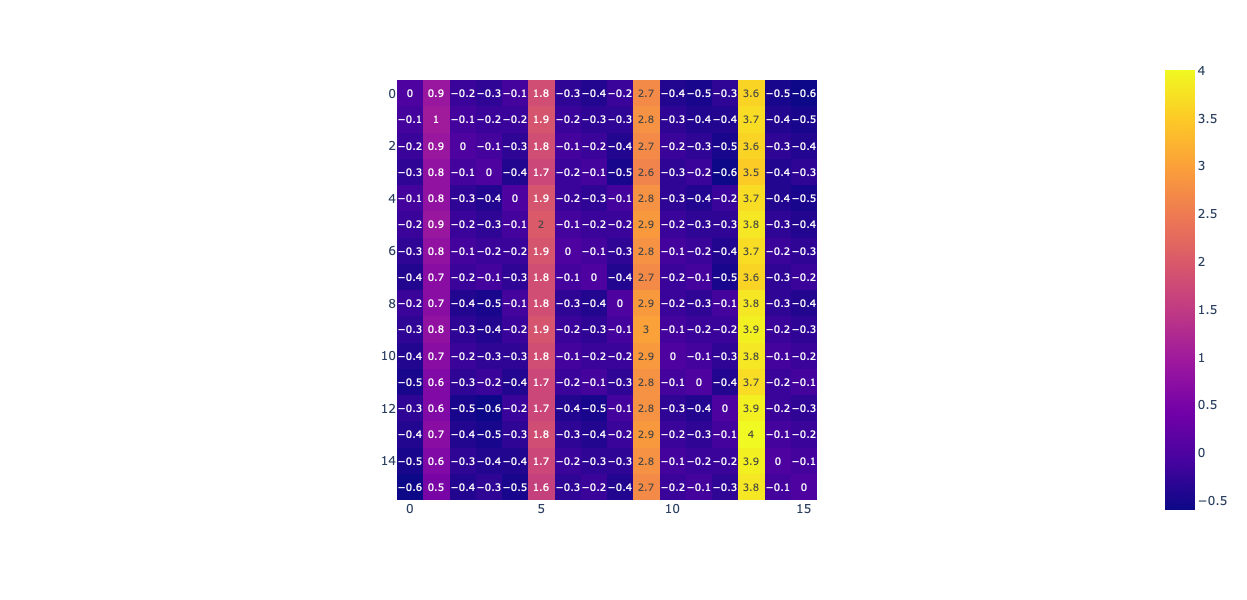


Critic Rewards


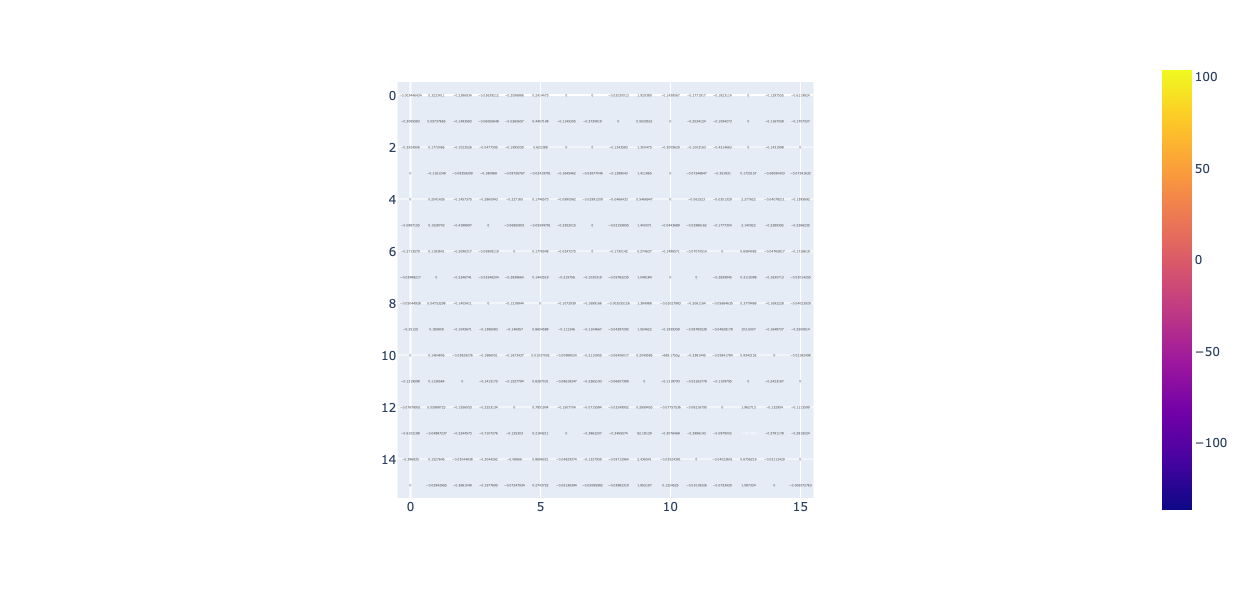


Actor Array


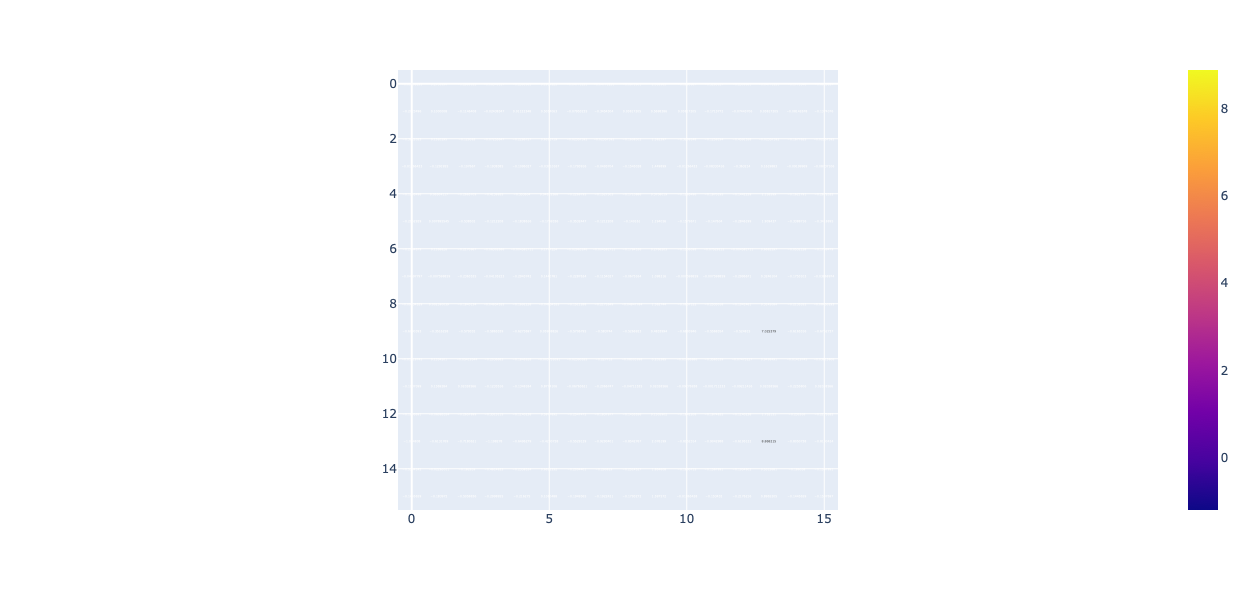


Reward Tracking


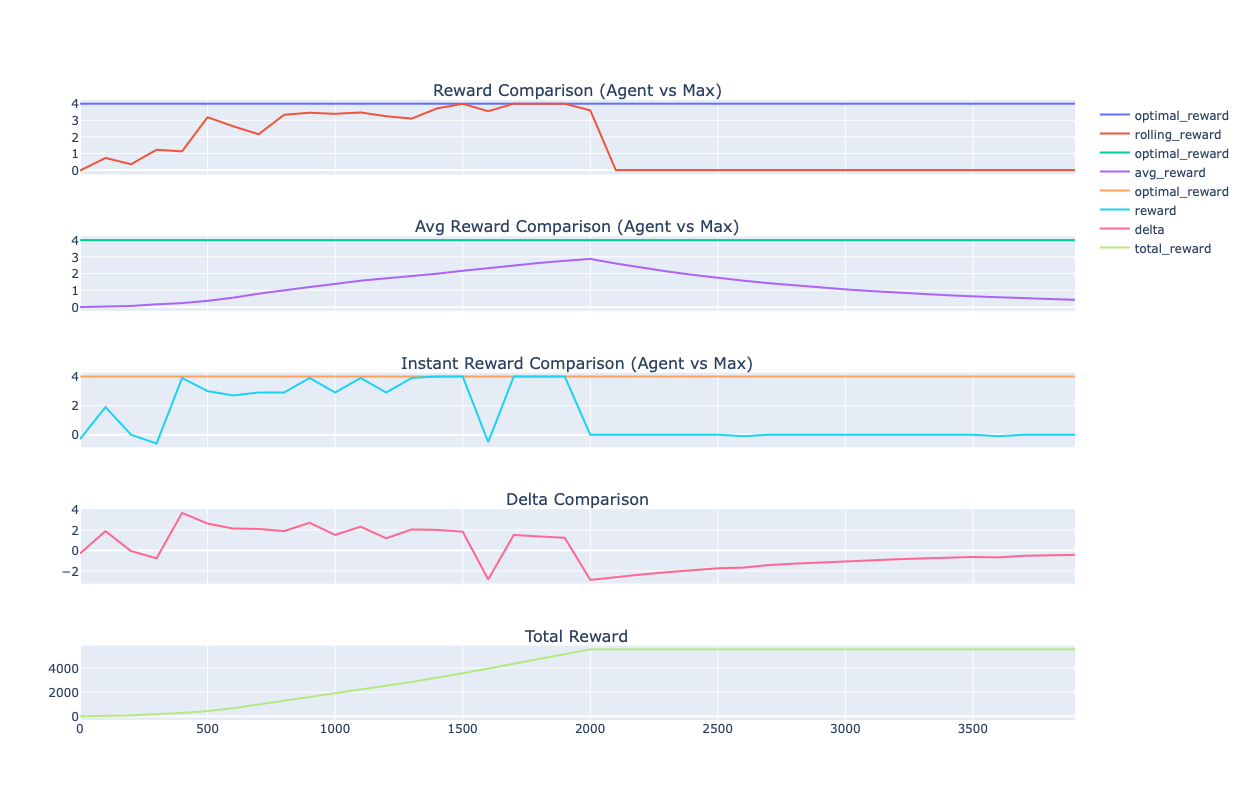

In [200]:
assess_step(exp_env, exp_agent, env_1d_mapping, running_dict_list)

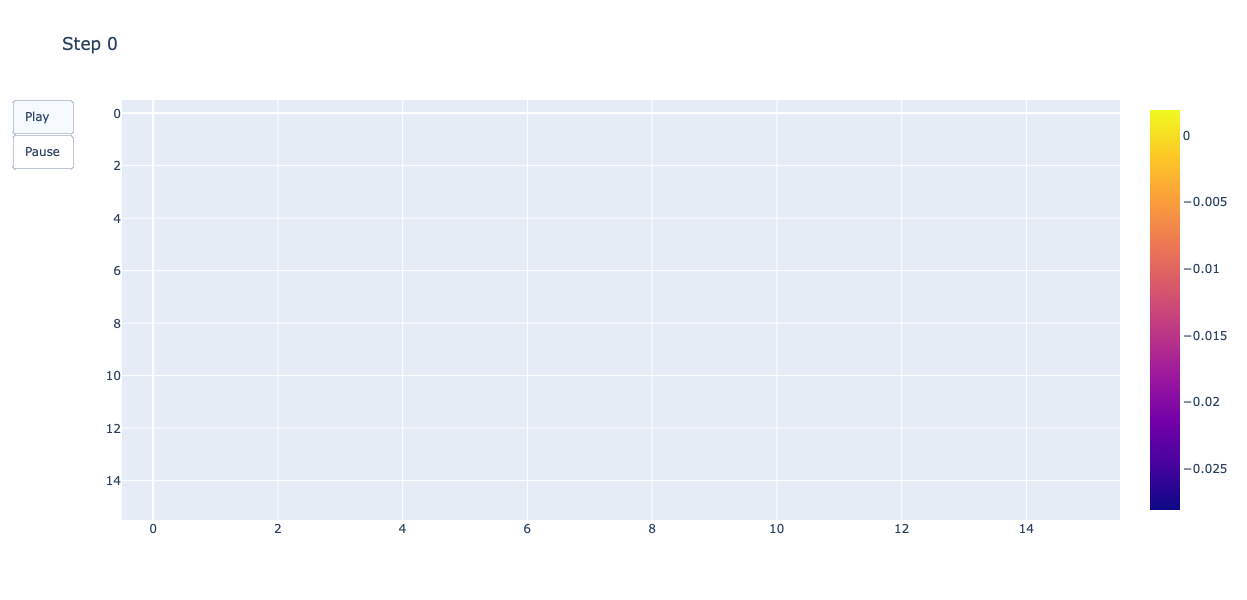

In [188]:
plot_array_evolution({x['step']:{'actor_array': x['actor_array']} for x in running_dict_list}, exp_interval=logging_interval, field='actor_array', width_plot=600, height_plot=600)

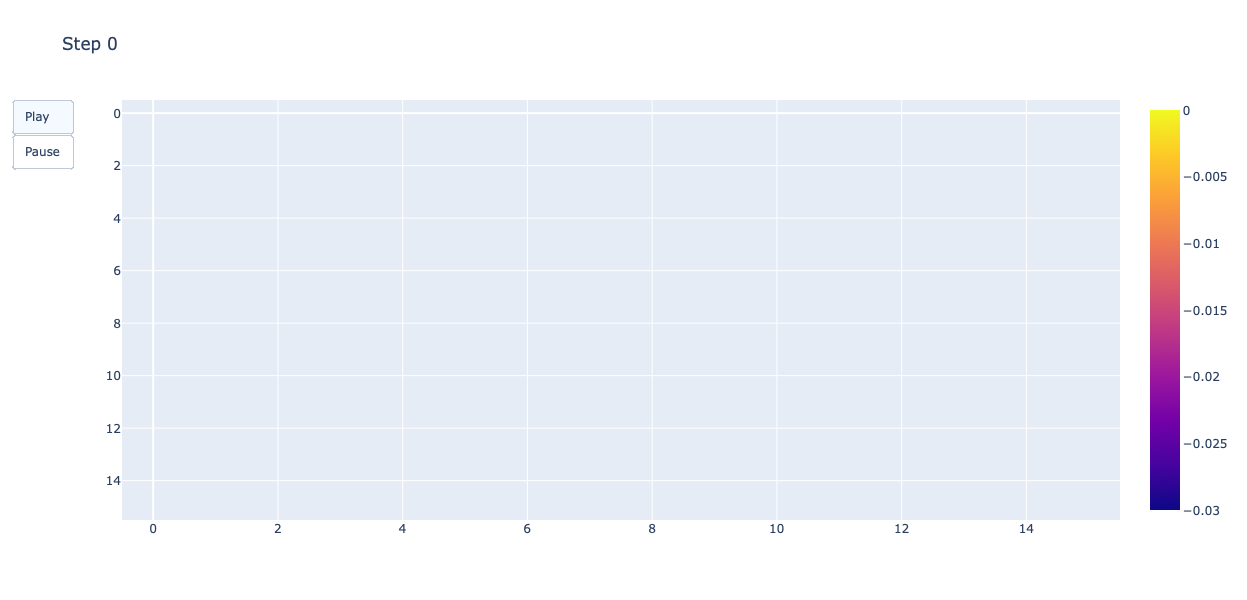

In [201]:
plot_array_evolution({x['step']:{'critic_array': x['critic_array']} for x in running_dict_list}, exp_interval=logging_interval, field='critic_array', width_plot=600, height_plot=600)

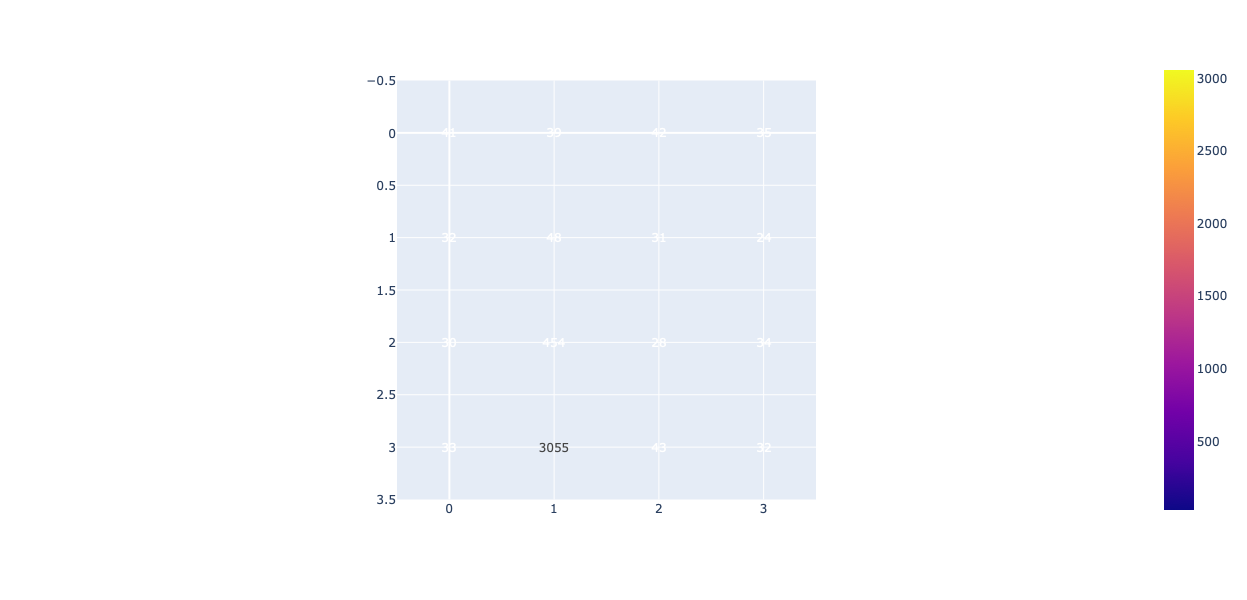

In [87]:
px.imshow(exp_agent.get_state_visits(), text_auto=True, width=600, height=600)